In [12]:
import numpy as np
import pandas as pd
import scipy
from scipy import integrate, interpolate, stats, special
from pathlib import Path
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.special
from tqdm import tqdm
import git 
import math
np.random.seed(42)

In [2]:
def gen_gamma_mean(r, eta):
    return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)

def gen_gamma_variance(r, eta):
    mean = gen_gamma_mean(r, eta)
    second_moment = scipy.special.gamma((eta+3.5)/r) / scipy.special.gamma((eta+1.5)/r)
    return second_moment - mean**2

def find_eta_for_target_mean(r, target_mean):
    def objective(eta):
        return (gen_gamma_mean(r, eta) - target_mean)**2
    result = scipy.optimize.minimize_scalar(objective, bounds=(0, 1e3))
    return result.x

def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis

In [64]:
all_r_vals = []
all_eta_vals = []
target_vars = np.round(np.arange(1.5, 3, 0.1), 2)

for target_mean in target_vars:

    r_vals = []
    eta_vals = []
    mean_vals = []
    variance_vals = []

    for r in np.arange(2.25,10,0.25):
        eta = find_eta_for_target_mean(r, target_mean)
        mean = gen_gamma_mean(r, eta)
        variance = gen_gamma_variance(r, eta)
        if variance == np.nan or mean == np.nan or math.isnan(eta):
            break
        
        r_vals.append(r)
        eta_vals.append(eta)
        mean_vals.append(mean)
        variance_vals.append(variance)

    all_r_vals.append(np.array(r_vals))
    all_eta_vals.append(np.array(eta_vals))

all_r_vals[0].shape
all_eta_vals[0].shape

C:\Users\yashd\AppData\Local\Temp\ipykernel_38412\3592043928.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


(31,)

Text(0, 0.5, '$\\eta$')

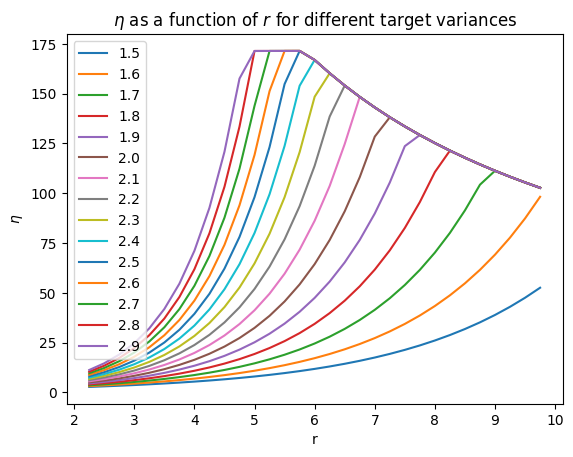

In [65]:
for i, (r_vals, eta_vals) in enumerate(zip(all_r_vals, all_eta_vals)):

    beta_vals = np.divide((eta_vals + 1.5), r_vals)
    sns.lineplot(x = r_vals, 
                 y = beta_vals,
                 label = f'{target_vars[i]}'
                 )
plt.title(f'$\\eta$ as a function of $r$ for different target variances')
plt.xlabel('r')
plt.ylabel(f'$\\eta$')


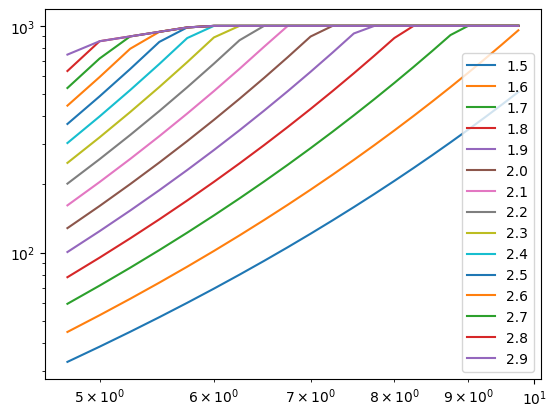

In [69]:
filter_vals = np.arange(len(r_vals))[10:]
for i, (r_vals, eta_vals) in enumerate(zip(all_r_vals, all_eta_vals)):
    sns.lineplot(x = r_vals[filter_vals], y = eta_vals[filter_vals], label = f'{target_vars[i]}')
    plt.xscale('log')
    plt.yscale('log')

C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\2306471237.py:5: RuntimeWarning: invalid value encountered in log
  sns.regplot(x=np.log(r_values)[start:], y=np.log(eta_values)[start:],


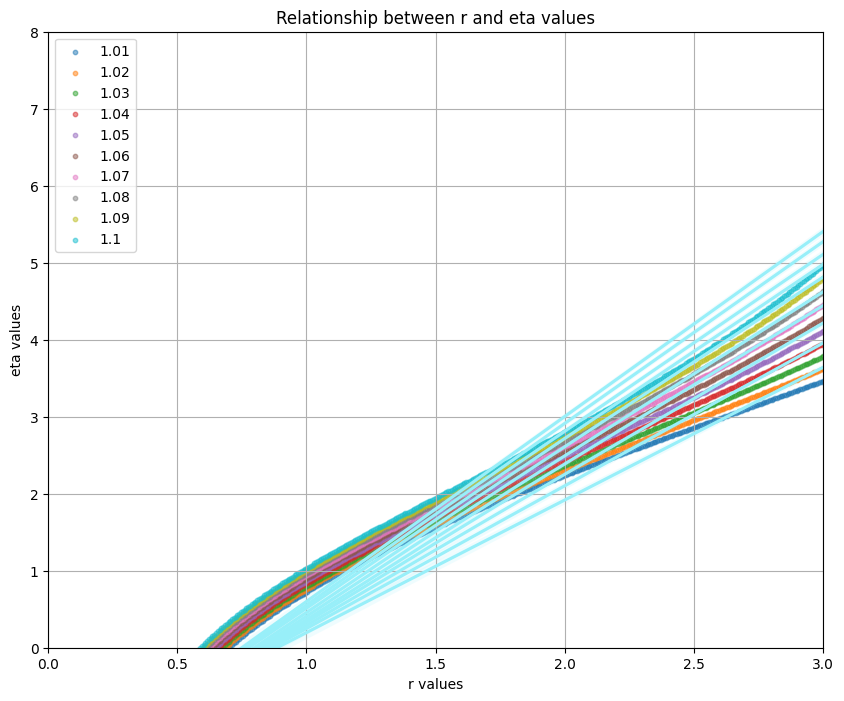

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
start = 0

for i, (r_vals, eta_vals) in enumerate(zip(all_r_vals, all_eta_vals)):
    sns.regplot(x=np.log(r_vals)[start:], y=np.log(eta_vals)[start:], 
                scatter_kws={'s': 10, 'alpha': 0.5},
                line_kws={'color': 'xkcd:robin\'s egg blue'},
                label=f'{target_vars[i]}',
                ax=ax)

plt.xlim(0, 3)
plt.ylim(0, 8)

#ax.set_xscale('log')
#ax.set_yscale('log')

plt.xlabel('r values')
plt.ylabel('eta values')
plt.title('Relationship between r and eta values')
plt.legend()
plt.grid(which='both')
plt.show()

C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\1502963218.py:5: RuntimeWarning: invalid value encountered in log
  sns.regplot(x=np.log(r_values)[start:]-3, y=2*np.log(eta_values)[start:],
C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\1502963218.py:10: RuntimeWarning: invalid value encountered in log
  sns.regplot(x=np.log(r_values)[start:]-3, y=-2*np.log(eta_values)[start:],
C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\1502963218.py:16: RuntimeWarning: invalid value encountered in log
  sns.regplot(x=-np.log(r_values)[start:], y=2*np.log(eta_values)[start:],
C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\1502963218.py:21: RuntimeWarning: invalid value encountered in log
  sns.regplot(x=-np.log(r_values)[start:], y=-2*np.log(eta_values)[start:],
C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\1502963218.py:5: RuntimeWarning: divide by zero encountered in log
  sns.regplot(x=np.log(r_values)[start:]-3, y=2*np.log(eta_values)[start:],
C:\Users\yashd\AppData\Local\Temp\ip

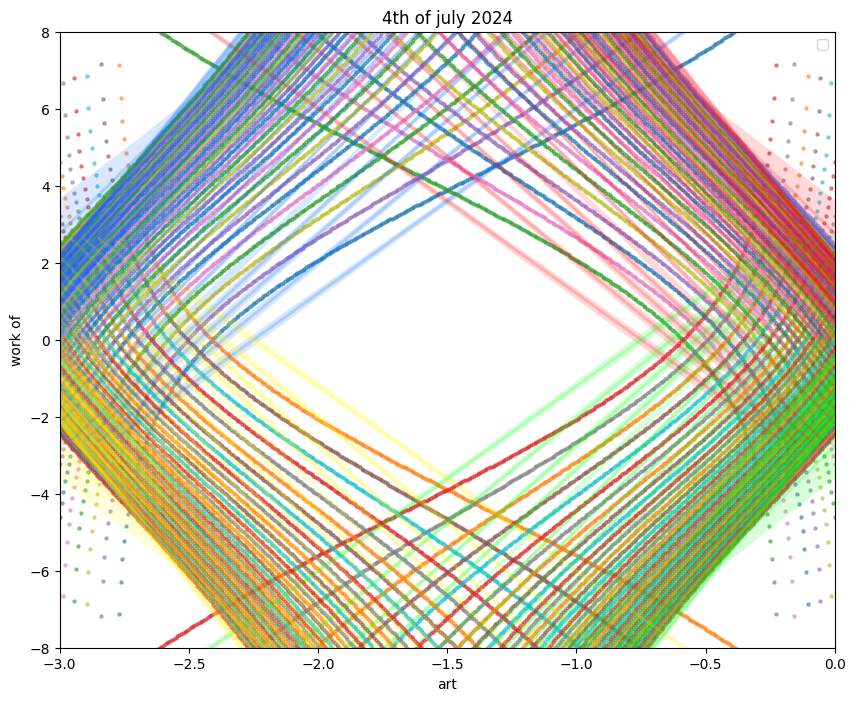

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
start = 0

for i, (r_vals, eta_vals) in enumerate(zip(all_r_vals, all_eta_vals)):
    sns.regplot(x=np.log(r_vals)[start:]-3, y=2*np.log(eta_vals)[start:], 
                scatter_kws={'s': 5, 'alpha': 0.5},
                line_kws={'color': 'xkcd:bright blue', 'alpha' : 0.2},
                #label=f'{target_means[i]}',
                ax=ax)
    sns.regplot(x=np.log(r_vals)[start:]-3, y=-2*np.log(eta_vals)[start:], 
                scatter_kws={'s': 5, 'alpha': 0.5},
                line_kws={'color': 'xkcd:bright yellow', 'alpha' : 0.2},
                #label=f'-{target_means[i]}',
                ax=ax)
    
    sns.regplot(x=-np.log(r_vals)[start:], y=2*np.log(eta_vals)[start:], 
                scatter_kws={'s': 5, 'alpha': 0.5},
                line_kws={'color': 'xkcd:bright red', 'alpha' : 0.2},
                #label=f'{target_means[i]}',
                ax=ax)
    sns.regplot(x=-np.log(r_vals)[start:], y=-2*np.log(eta_vals)[start:], 
                scatter_kws={'s': 5, 'alpha': 0.5},
                line_kws={'color': 'xkcd:bright green', 'alpha' : 0.2},
                #label=f'-{target_means[i]}',
                ax=ax)

plt.xlim(-3, 0)
plt.ylim(-8, 8)

#ax.set_xscale('log')
#ax.set_yscale('log')

plt.xlabel('art')
plt.ylabel('work of')
plt.title('4th of july 2024')
plt.legend()
#plt.grid(which='both')
plt.show()

C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\182390930.py:5: RuntimeWarning: invalid value encountered in log
  sns.regplot(x=np.log(r_values)[start:], y=np.log(eta_values)[start:],
C:\Users\yashd\AppData\Local\Temp\ipykernel_42512\182390930.py:5: RuntimeWarning: divide by zero encountered in log
  sns.regplot(x=np.log(r_values)[start:], y=np.log(eta_values)[start:],


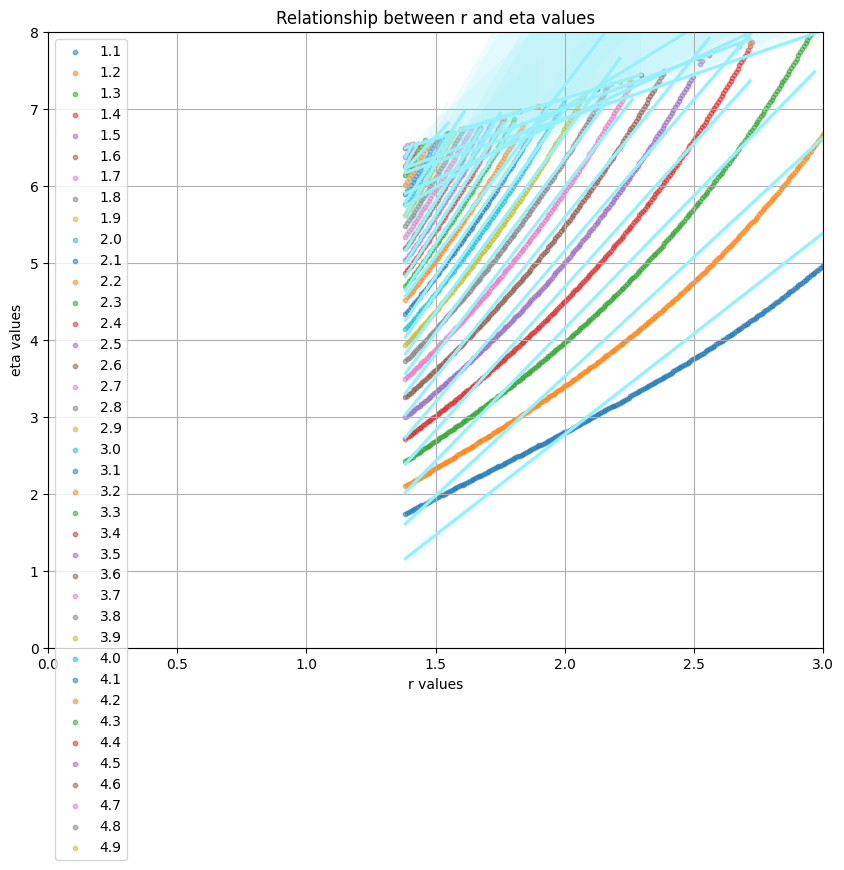

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
start = 200

for i, (r_vals, eta_vals) in enumerate(zip(all_r_vals, all_eta_vals)):
    sns.regplot(x=np.log(r_vals)[start:], y=np.log(eta_vals)[start:], 
                scatter_kws={'s': 10, 'alpha': 0.5},
                line_kws={'color': 'xkcd:robin\'s egg blue'},
                label=f'{target_vars[i]}',
                ax=ax)

plt.xlim(0, 3)
plt.ylim(0, 8)

#ax.set_xscale('log')
#ax.set_yscale('log')

plt.xlabel('r values')
plt.ylabel('eta values')
plt.title('Relationship between r and eta values')
plt.legend()
plt.grid(which='both')
plt.show()

<Axes: >

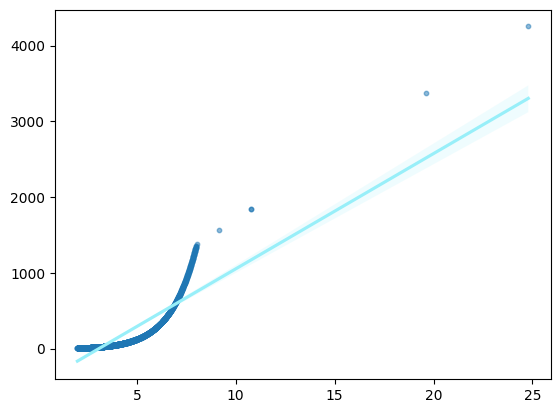

In [ ]:
sns.regplot(x=r_vals[1000:-500], y=eta_vals[1000:-500], 
                scatter_kws={'s': 10, 'alpha': 0.5},
                line_kws={'color': 'xkcd:robin\'s egg blue'},
                label=f'{target_vars[i]}')

No Tail
No Tail


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:313: RuntimeWarning: overflow encountered in scalar power
  return (abs(r)/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:313: RuntimeWarning: invalid value encountered in scalar multiply
  return (abs(r)/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:319: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calli

ValueError: cannot convert float NaN to integer

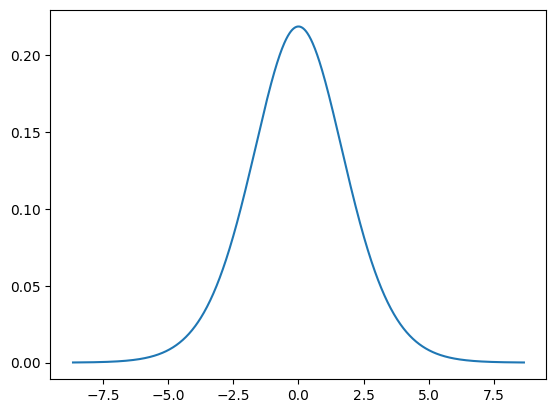

In [ ]:
r_vals, eta_vals, target_mean = all_r_vals[i], all_eta_vals[i], target_vars[i]
for i in range(0, len(r_vals), len(r_vals)//8)[1:-3]:
    xs, pdf = compute_prior_pdf(r_vals[i], eta_vals[i], n_samples=1000)
    plt.plot(xs, pdf, label = f'r = {round_to_sigfigs(r_vals[i], 4)}, eta = {round_to_sigfigs(eta_vals[i], 4)}')
plt.plot(xs, stats.norm(scale=target_mean).pdf(xs), label = f'Normal(0, {target_mean})')

plt.legend(loc='lower left')
plt.savefig('images/gengamma_gaussian_analysis_var2.png', bbox_inches = 'tight')

No Tail
No Tail
No Tail
No Tail


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:313: RuntimeWarning: overflow encountered in scalar power
  return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:313: RuntimeWarning: invalid value encountered in scalar multiply
  return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:319: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


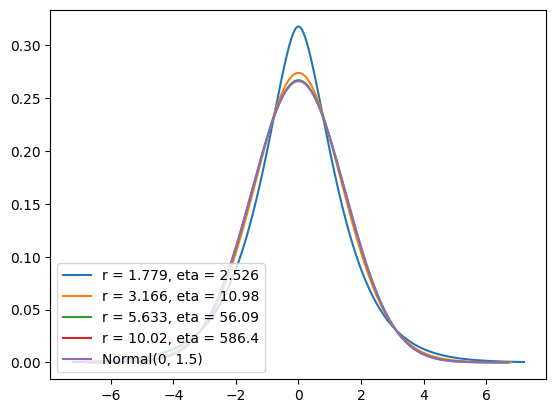

In [ ]:
r_vals, eta_vals = r15_values, eta15_values
target_mean = 1.5
for i in range(0, len(r_vals), len(r_vals)//8)[1:-3]:
    xs, pdf = compute_prior_pdf(r_vals[i], eta_vals[i], n_samples=1000)
    plt.plot(xs, pdf, label = f'r = {round_to_sigfigs(r_vals[i], 4)}, eta = {round_to_sigfigs(eta_vals[i], 4)}')
plt.plot(xs, stats.norm(scale=1.5).pdf(xs), label = f'Normal(0, 1.5)')

plt.legend(loc='lower left')
plt.savefig('images/gengamma_gaussian_analysis_var15.png', bbox_inches = 'tight')

No Tail
No Tail
No Tail
No Tail


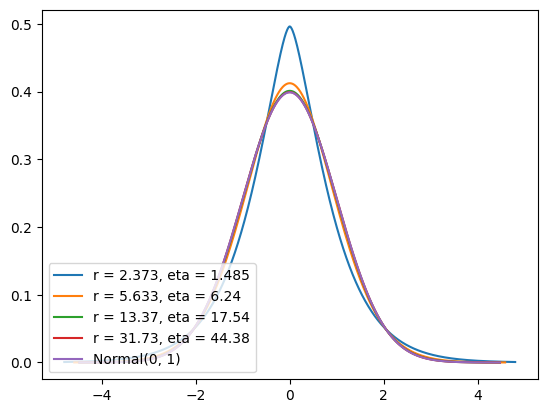

In [ ]:
r_vals, eta_vals = r1_values, eta1_values
target_mean = 1
for i in range(0, len(r_vals), len(r_vals)//8)[1:-3]:
    xs, pdf = compute_prior_pdf(r_vals[i], eta_vals[i], n_samples=1000)
    plt.plot(xs, pdf, label = f'r = {round_to_sigfigs(r_vals[i], 4)}, eta = {round_to_sigfigs(eta_vals[i], 4)}')
plt.plot(xs, stats.norm(scale=target_mean).pdf(xs), label = f'Normal(0, {target_mean})')

plt.legend(loc='lower left')
plt.savefig('images/gengamma_gaussian_analysis_var1.png', bbox_inches = 'tight')

In [ ]:
xs1, pdf1 = compute_prior_pdf(r15_values[5], eta15_values[5])
xs2, pdf2 = compute_prior_pdf(32.30, 45.82)
xs3, pdf3 = compute_prior_pdf(8.11, 9.86)
for i in range(0, len(r2_values), len(r2_values)//10):
    

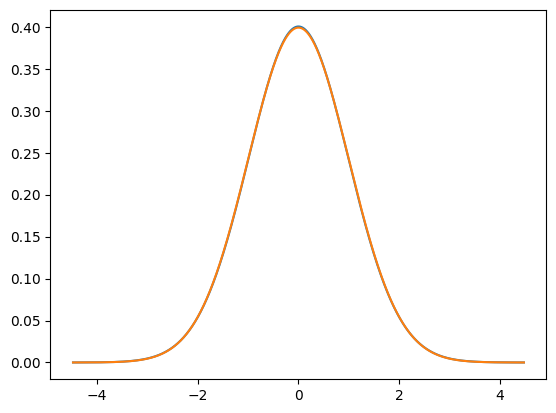

In [ ]:
#plt.plot(xs1, stats.norm(scale=2).pdf(xs1), label = 'Normal')
plt.plot(xs1, pdf1, )
plt.plot(xs2, pdf2)
plt.legend()

No Tail
No Tail
No Tail


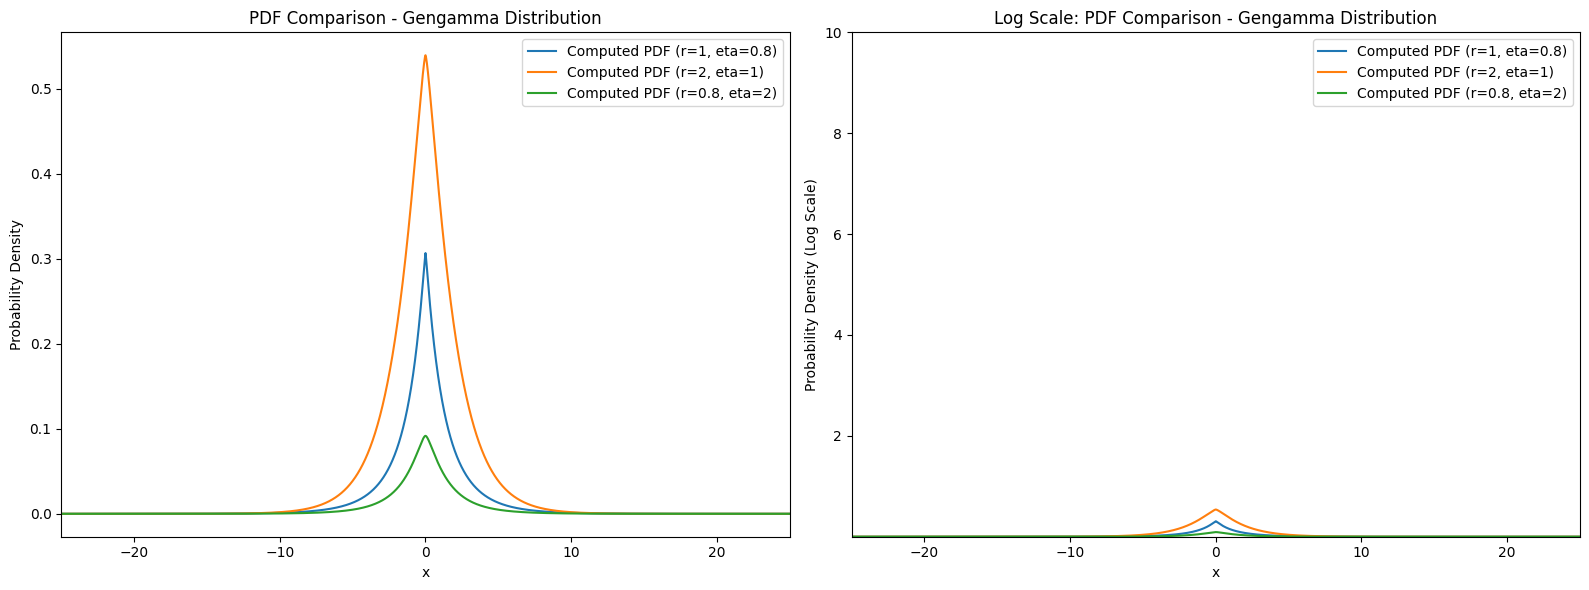

In [ ]:
params_list = [(1, 0.8), (2, 1), (0.8, 2)]  # List of (r, eta) pairs for gengamma
sample_data = np.random.normal(0, 1, 1000)  # Optional sample data
fig = visualize_pdf(params_list, distro='gengamma')
plt.show()

No Tail


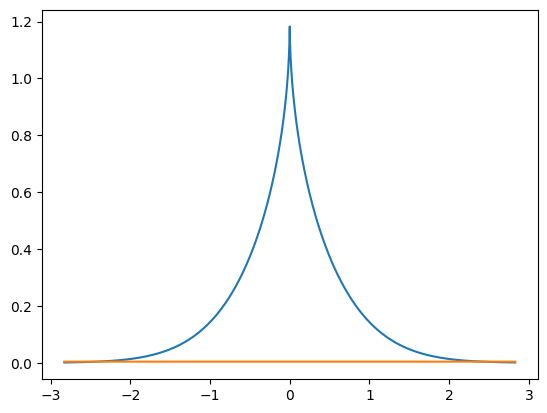

In [ ]:
xs, pdf = compute_prior_pdf(r_test- 50, eta_test)
plt.plot(xs, pdf)
plt.plot(xs, stats.norm(scale = target_mean).pdf(xs))

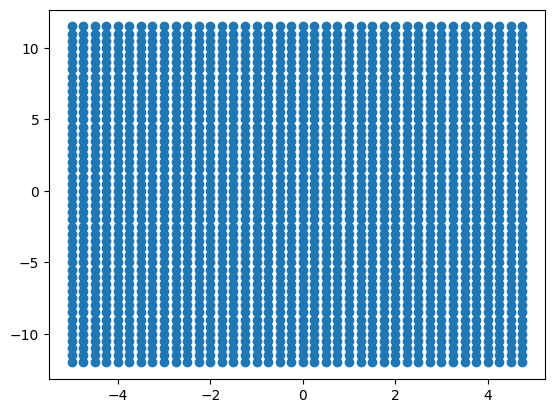

In [3]:
r_vals = np.arange(-5, 5, 0.25) # np.append(np.arange(-3, -0.2, 0.2), np.arange(0.5, 10, 0.5))
eta_vals = np.arange(-12, 12, 0.5) # np.append(np.linspace(-5, -0.5, 10), np.linspace(0, 5, 10))
resx, resy = np.meshgrid(r_vals, eta_vals)
plt.scatter(resx, resy)

In [5]:
def sample_prior(r, eta, size=1):
    '''
    Samples from prior distribution of signal x
    r : shape parameter, must be nonzero
    eta : shape parameter, controls roundedness of peak, must be > 0
    size : integer specifying number of samples required
    Note that the model is paramterized such that the generalized gamma variables are the variances (not the standard deviation)
    '''
    vars = stats.gengamma.rvs(a = (eta + 1.5)/r, c = r, size = size)
    x = np.random.normal(scale = np.sqrt(vars), size=size)
    return x

In [6]:
np.seterr(divide = 'ignore')
np.seterr(invalid = 'ignore') 
cond1, cond2, cond3 = [], [], []

def get_prior_var(r, eta):
    beta = (eta + 1.5)/r
    return scipy.special.gamma(beta + 1/r) / scipy.special.gamma(beta)

r_vals = np.append(np.arange(-4, 0, 0.1), np.arange(0.5, 8, 0.1))
eta_vals = np.arange(-4, 2, 0.1) 

df = pd.DataFrame(columns = ['r', 'eta', 'beta', 'beta+1/r', 'empirical_mean', 'empirical_var', 'computed_var', '% error'])
i = 0
mu = []
var = []
for i in tqdm(range(len(r_vals))):
    for eta in eta_vals:
        r = r_vals[i]

        beta = (eta+1.5)/r
        
        if beta <= 0:
            cond1.append((r, eta))
            continue
        
        if beta + 1/r <= 0:
            cond2.append((r, eta))
            # continue

        if 0 < beta + 1/r <= 1:
            cond3.append((r, eta))
            # continue
        for _ in range(10):
            x = sample_prior(r, eta, 1000)
            mu.append(np.mean(x))
            var.append(np.var(x))

        computed_var = get_prior_var(r, eta)
        
        df.loc[i, ] = r, eta, (eta+1.5)/r, ((eta+1.5)/r + 1/r), np.mean(mu), np.mean(var), computed_var, np.abs(np.mean(var) - computed_var)/np.mean(var)  * 100
        i += 1

print(df['% error'].mean())

def mapping(x):
    if x < 0:
        return 'negative var'
    else:
        return 'positive var'


df['cond_computed'] = df['computed_var'].apply(mapping)
sns.scatterplot(data=df, x = 'r', y = 'eta', hue = 'cond_computed')

  0%|          | 0/115 [00:00<?, ?it/s]

 70%|███████   | 81/115 [01:21<00:34,  1.01s/it]


IndexError: index 115 is out of bounds for axis 0 with size 115

<Axes: xlabel='r', ylabel='eta'>

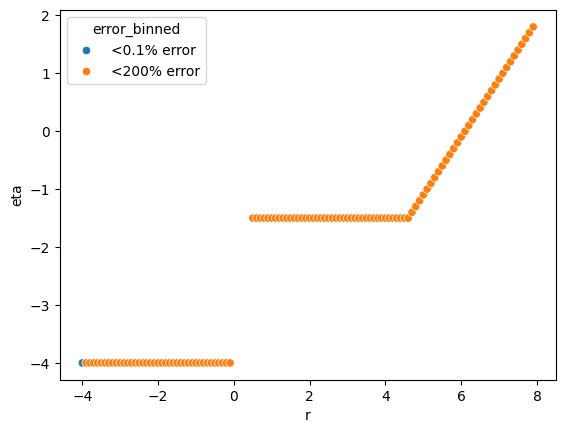

In [21]:
def mapping(x):
    if x < 0.1:
        return '<0.1% error'
    elif x < 1:
        return '<1% error'
    elif x < 5:
        return '<5% error'
    elif x < 20:
        return '<20% error'
    elif x < 200:
        return '<200% error'
    elif x < 1000:
        return '<1000% error'
    else:
        return 'unreasonable error'


df['error_binned'] = df['% error'].apply(mapping)
sns.scatterplot(data=df, x = 'r', y = 'eta', hue = 'error_binned')

In [ ]:
df

,r,eta,beta,beta+1/r,empirical_mean,empirical_var,computed_var,% error,cond_computed,error_binned
0,-4.0,-4.0,0.625,0.375,-0.002045,1.647988,1.652426,0.269268,positive var,<5% error
1,-4.0,-3.9,0.6,0.35,-0.006423,1.712516,1.70975,0.161474,positive var,<5% error
2,-4.0,-3.8,0.575,0.325,-0.000853,1.796198,1.775291,1.163939,positive var,<5% error
3,-4.0,-3.7,0.55,0.3,0.001073,1.87552,1.851076,1.303303,positive var,<5% error
4,-4.0,-3.6,0.525,0.275,-0.007251,1.936835,1.939868,0.156578,positive var,<5% error
...,...,...,...,...,...,...,...,...,...,...
3620,7.9,1.5,0.379747,0.506329,-0.001987,0.746514,0.748221,0.228681,positive var,<5% error
3621,7.9,1.6,0.392405,0.518987,0.002063,0.759767,0.755489,0.563064,positive var,<5% error
3622,7.9,1.7,0.405063,0.531646,-0.004614,0.761624,0.762474,0.111614,positive var,<5% error
3623,7.9,1.8,0.417722,0.544304,-0.000005,0.765282,0.769194,0.511185,positive var,<5% error


<Axes: xlabel='r', ylabel='eta'>

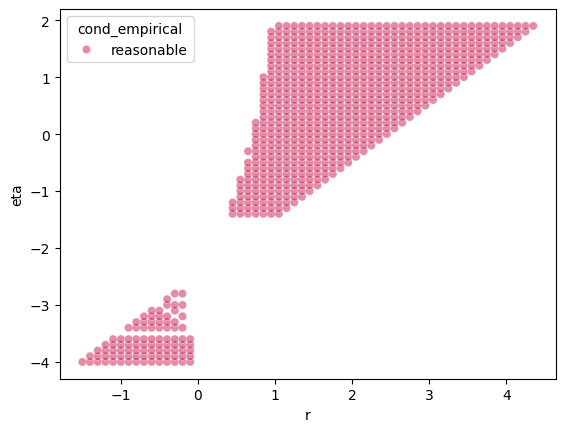

In [ ]:
df['cond_empirical'] = df['empirical_var'].apply(mapping)
sns.scatterplot(data=df[df['% error'] < 10000000000], x = 'r', y = 'eta', hue = 'cond_empirical', alpha = 0.5, palette = 'rocket')